# A Machine Learning Approach to Reducing Missed Appointments to Improve health efficiency and Resource Utilisation

Objective:
To reduce missed medical appointments (no-shows) by predicting patient attendance 
using SQL-based data preprocessing, GitHub version control, Tableau for visual insight, 
and Python machine learning models.

In [ ]:
# --- Core Libraries ---
import pandas as pd                      # For data manipulation and analysis
import numpy as np                       # For numerical operations and arrays
from collections import Counter          # For counting class distributions

# --- Visualization ---
import matplotlib.pyplot as plt          # For plotting
import seaborn as sns                    # For statistical plots
sns.set(style='whitegrid')              # Apply seaborn's whitegrid style

# --- SHAP for Explainability ---
import shap                              # For model interpretability (tree-based models)

# --- Model Selection & Pipeline ---
from sklearn.model_selection import (
    train_test_split,                    # Splits dataset into train and test sets
    GridSearchCV,                        # Performs hyperparameter tuning
    StratifiedKFold                      # Ensures class distribution across folds
)
from sklearn.preprocessing import StandardScaler     # Standardizes features
from sklearn.pipeline import Pipeline                # Creates ML pipelines

# --- Evaluation Metrics ---
from sklearn.metrics import (
    accuracy_score,                      # Basic accuracy
    balanced_accuracy_score,             # Useful for imbalanced data
    precision_score,                     # True positives / predicted positives
    recall_score,                        # True positives / actual positives
    f1_score,                            # Harmonic mean of precision and recall
    roc_auc_score,                       # AUC for ROC curve
    roc_curve,                           # ROC curve values
    classification_report,              # Full metric report
    confusion_matrix,                   # Confusion matrix
    ConfusionMatrixDisplay              # Confusion matrix visualization
)

# --- Classifiers ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier        

# --- Sampling Techniques for Imbalanced Data ---
from imblearn.over_sampling import SMOTE                    # Over-sampling
from imblearn.under_sampling import (
    RandomUnderSampler,                                     # Under-sampling
    NeighbourhoodCleaningRule                               # Cleans noisy majority class samples
)
from imblearn.pipeline import Pipeline as ImbPipeline       # Avoid conflict with sklearn's Pipeline

In [2]:
# Load and preview the dataset
df = pd.read_csv('Patient_Appointment_Attendance.csv')
print("First 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset info:")
print(df.info())

First 5 rows of the dataset:
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1        

In [3]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("\nMissing values in each column (if any):")
print(missing_values)

# Check number of unique values for each column
unique_values = df.nunique().sort_values(ascending=False)
print("\nUnique values in each column:")
print(unique_values)


Number of duplicate rows: 0

Missing values in each column (if any):
Series([], dtype: int64)

Unique values in each column:
AppointmentID     110527
ScheduledDay      103549
PatientId          62299
Age                  104
Neighbourhood         81
AppointmentDay        27
Handcap                5
Gender                 2
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
SMS_received           2
No-show                2
dtype: int64


In [4]:
# Examine unique values in 'Handcap' column before transformation
unique_handcap_values = df['Handcap'].value_counts().sort_index()
print("\nUnique values in 'Handcap' column before binarization:")
print(unique_handcap_values)

# Binarize 'Handcap': 0 for no disability, 1 for any level of disability
df['Handcap'] = df['Handcap'].apply(lambda x: 1 if x > 0 else 0)

# Confirm the changes to 'Handcap'
handcap_binarized_counts = df['Handcap'].value_counts()
print("\nCounts of binarized 'Handcap' values:")
print(handcap_binarized_counts)


Unique values in 'Handcap' column before binarization:
Handcap
0    108286
1      2042
2       183
3        13
4         3
Name: count, dtype: int64

Counts of binarized 'Handcap' values:
Handcap
0    108286
1      2241
Name: count, dtype: int64


In [5]:
# Examine unique values in 'Age' column before transformation
unique_age_values = df['Age'].value_counts().sort_index()
print("\nUnique values in 'Age' column before binarization:")
print(unique_age_values)

# Drop rows with invalid age values
df = df[df['Age'] >= 0]

# Confirm the update
print("Minimum age after cleaning:", df['Age'].min())
print("Maximum age after cleaning:", df['Age'].max())


Unique values in 'Age' column before binarization:
Age
-1         1
 0      3539
 1      2273
 2      1618
 3      1513
        ... 
 98        6
 99        1
 100       4
 102       2
 115       5
Name: count, Length: 104, dtype: int64
Minimum age after cleaning: 0
Maximum age after cleaning: 115


In [6]:
# Encode 'Gender' as binary: 0 for Female, 1 for Male
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})
print("\nUnique values in 'Gender' after encoding:")
print(df['Gender'].value_counts())

# Convert date columns to datetime objects with timezone awareness
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], utc=True)
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], utc=True)

# Create 'LeadTime' feature: days between scheduling and appointment
df['LeadTime'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

# Extract day of the week for the appointment
df['AppointmentWeekday'] = df['AppointmentDay'].dt.dayofweek  # Monday=0, Sunday=6

# Encode 'No-show' as binary: 0 = showed up, 1 = no-show
df['No_show_Int'] = df['No-show'].map({'No': 0, 'Yes': 1})
print("\nEncoded 'No_show_Int' column value counts:")
print(df['No_show_Int'].value_counts())


Unique values in 'Gender' after encoding:
Gender
0    71839
1    38687
Name: count, dtype: int64

Encoded 'No_show_Int' column value counts:
No_show_Int
0    88207
1    22319
Name: count, dtype: int64


In [7]:
# Examine unique values in 'LeadTime' column before transformation
unique_leadtime_values = df['LeadTime'].value_counts().sort_index()
print("\nUnique values in 'LeadTime' column before binarization:")
print(unique_leadtime_values)


Unique values in 'LeadTime' column before binarization:
LeadTime
-7          1
-2          4
-1      38562
 0       5213
 1       6725
        ...  
 154       10
 161       11
 168        8
 175       16
 178       10
Name: count, Length: 131, dtype: int64


In [8]:
# Preview the Dataset
print("First 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset info:")
print(df.info())

First 5 rows of the dataset:
      PatientId  AppointmentID  Gender              ScheduledDay  \
0  2.987250e+13        5642903       0 2016-04-29 18:38:08+00:00   
1  5.589978e+14        5642503       1 2016-04-29 16:08:27+00:00   
2  4.262962e+12        5642549       0 2016-04-29 16:19:04+00:00   
3  8.679512e+11        5642828       0 2016-04-29 17:29:31+00:00   
4  8.841186e+12        5642494       0 2016-04-29 16:07:23+00:00   

             AppointmentDay  Age      Neighbourhood  Scholarship  \
0 2016-04-29 00:00:00+00:00   62    JARDIM DA PENHA            0   
1 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   
2 2016-04-29 00:00:00+00:00   62      MATA DA PRAIA            0   
3 2016-04-29 00:00:00+00:00    8  PONTAL DE CAMBURI            0   
4 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   

   Hipertension  Diabetes  Alcoholism  Handcap  SMS_received No-show  \
0             1         0           0        0             0      No   
1        

In [9]:
# Filter rows with negative LeadTime
negative_leadtime_rows = df[df['LeadTime'] < 0]

# Print the number of rows with negative LeadTime
print("Number of rows with negative LeadTime:", negative_leadtime_rows.shape[0])

# Print the first 5 rows with negative LeadTime for inspection
print("\nSample rows with negative LeadTime:")
print(negative_leadtime_rows.head())

Number of rows with negative LeadTime: 38567

Sample rows with negative LeadTime:
      PatientId  AppointmentID  Gender              ScheduledDay  \
0  2.987250e+13        5642903       0 2016-04-29 18:38:08+00:00   
1  5.589978e+14        5642503       1 2016-04-29 16:08:27+00:00   
2  4.262962e+12        5642549       0 2016-04-29 16:19:04+00:00   
3  8.679512e+11        5642828       0 2016-04-29 17:29:31+00:00   
4  8.841186e+12        5642494       0 2016-04-29 16:07:23+00:00   

             AppointmentDay  Age      Neighbourhood  Scholarship  \
0 2016-04-29 00:00:00+00:00   62    JARDIM DA PENHA            0   
1 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   
2 2016-04-29 00:00:00+00:00   62      MATA DA PRAIA            0   
3 2016-04-29 00:00:00+00:00    8  PONTAL DE CAMBURI            0   
4 2016-04-29 00:00:00+00:00   56    JARDIM DA PENHA            0   

   Hipertension  Diabetes  Alcoholism  Handcap  SMS_received No-show  \
0             1         0   


It was observed that some values in the `LeadTime` column were negative. 
Further inspection revealed that in these cases, the `ScheduledDay` was recorded as occurring after the `AppointmentDay`, 
which is logically incorrect. Specifically, entries with a `LeadTime` of -1 corresponded to same-day scheduling and appointment. 
These values were therefore recoded to 0. 
Rows with `LeadTime` values less than -1 were considered erroneous and removed from the dataset, 
as they were both few in number and unlikely to contribute meaningfully to the model.

In [10]:
# Convert LeadTime == -1 to 0 (same-day scheduling and appointment)
df.loc[df['LeadTime'] == -1, 'LeadTime'] = 0

# Drop rows with LeadTime < -1 (invalid scheduling)
df = df[df['LeadTime'] >= -1]  # this now drops only rows less than -1

# Confirm the update
print("Number of rows after cleaning LeadTime:", df.shape[0])

Number of rows after cleaning LeadTime: 110521


In [11]:
print("Last 5 rows of the dataset:")
print(df.tail())

# Display dataset information
print("\nDataset info:")
print(df.info())

Last 5 rows of the dataset:
           PatientId  AppointmentID  Gender              ScheduledDay  \
110522  2.572134e+12        5651768       0 2016-05-03 09:15:35+00:00   
110523  3.596266e+12        5650093       0 2016-05-03 07:27:33+00:00   
110524  1.557663e+13        5630692       0 2016-04-27 16:03:52+00:00   
110525  9.213493e+13        5630323       0 2016-04-27 15:09:23+00:00   
110526  3.775115e+14        5629448       0 2016-04-27 13:30:56+00:00   

                  AppointmentDay  Age Neighbourhood  Scholarship  \
110522 2016-06-07 00:00:00+00:00   56   MARIA ORTIZ            0   
110523 2016-06-07 00:00:00+00:00   51   MARIA ORTIZ            0   
110524 2016-06-07 00:00:00+00:00   21   MARIA ORTIZ            0   
110525 2016-06-07 00:00:00+00:00   38   MARIA ORTIZ            0   
110526 2016-06-07 00:00:00+00:00   54   MARIA ORTIZ            0   

        Hipertension  Diabetes  Alcoholism  Handcap  SMS_received No-show  \
110522             0         0           0     

In [12]:
# Save the biased dataset
df.to_csv("Preprocessed_patient_appointment.csv", index=False)

In [13]:
# Drop unnecessary columns
df.drop(columns=["AppointmentID", "PatientId", "ScheduledDay", "AppointmentDay", "No-show", "AppointmentWeekday"], inplace=True)

# Confirm remaining columns
print("\nRemaining columns after drop:")
print(df.columns)

print("Last 5 rows of the dataset:")
print(df.tail())

# Display dataset information
print("\nDataset info:")
print(df.info())


Remaining columns after drop:
Index(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'LeadTime',
       'No_show_Int'],
      dtype='object')
Last 5 rows of the dataset:
        Gender  Age Neighbourhood  Scholarship  Hipertension  Diabetes  \
110522       0   56   MARIA ORTIZ            0             0         0   
110523       0   51   MARIA ORTIZ            0             0         0   
110524       0   21   MARIA ORTIZ            0             0         0   
110525       0   38   MARIA ORTIZ            0             0         0   
110526       0   54   MARIA ORTIZ            0             0         0   

        Alcoholism  Handcap  SMS_received  LeadTime  No_show_Int  
110522           0        0             1        34            0  
110523           0        0             1        34            0  
110524           0        0             1        40            0  
110525           0        0            

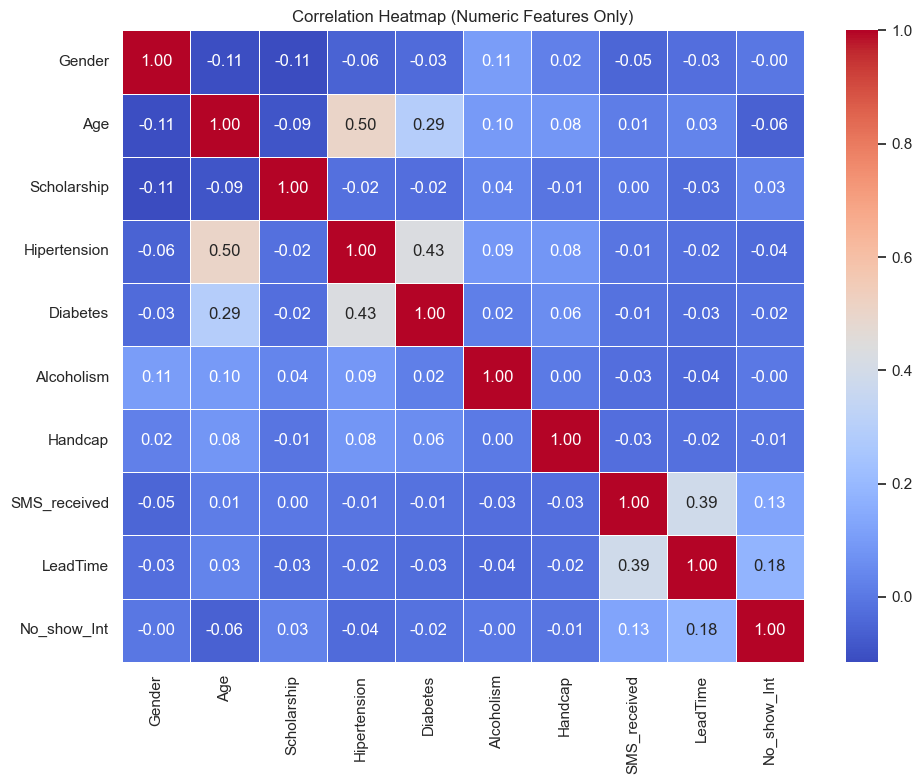

In [14]:
# Select numeric columns only
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title and layout
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.tight_layout()
plt.show()

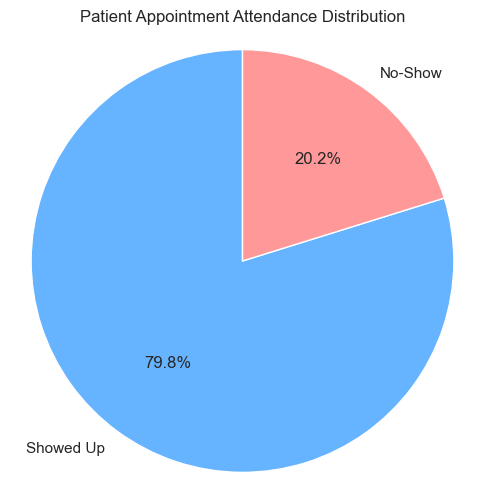

In [15]:
# Get value counts
no_show_counts = df['No_show_Int'].value_counts().sort_index()  # 0: showed up, 1: no-show

# Define labels
labels = ['Showed Up', 'No-Show']

# Define colors (optional)
colors = ['#66b3ff', '#ff9999']

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(no_show_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Patient Appointment Attendance Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is a circle
plt.show()

It was observed that the dataset was imbalanced, with a significant bias toward the majority class — patients who showed up for 
their appointments. This imbalance posed a risk of skewing the machine learning models toward favouring the majority class, 
potentially reducing their ability to accurately predict no-show instances. 
To address this, bias-mitigation techniques such as resampling methods were employed 
to ensure fairer and more reliable model performance across both classes.

In [16]:
# Create a random sample of 20000 rows from the original DataFrame
df_sample = df.sample(n=20000, random_state=42)  # random_state for reproducibility
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# --- Suppress Common Warnings ---
warnings.filterwarnings('ignore', category=UndefinedMetricWarning) 

### Machine Learning Models to Predict Patient Appointment Attendance

In [ ]:
# Create a random sample of 100000 rows from the original DataFrame
df_sample = df.sample(n=100000, random_state=42)  # random_state for reproducibility


# Features and target
X = df_sample.drop(columns=['No_show_Int'])
y = df_sample['No_show_Int']


# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,LeadTime,Neighbourhood_ANDORINHAS,...,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
22726,1,0,0,0,0,0,0,0,0,False,...,False,False,False,True,False,False,False,False,False,False
103094,0,72,0,0,0,0,0,0,1,False,...,False,False,False,False,False,False,False,False,False,False
45443,0,40,1,0,0,0,0,0,9,False,...,False,False,False,False,True,False,False,False,False,False
95808,0,61,0,0,0,0,1,0,0,False,...,False,False,False,False,False,False,False,False,False,False
46664,1,82,0,1,0,0,0,0,6,False,...,False,False,False,False,False,False,False,False,False,False



--- Running models with Basemodel data ---
y_train: Counter({0: 63845, 1: 16155})
y_test : Counter({0: 15961, 1: 4039})
X_train shape: (80000, 89)
X_test shape : (20000, 89)
Training LogisticRegression with Basemodel sampling...
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     15961
           1       0.32      0.01      0.03      4039

    accuracy                           0.79     20000
   macro avg       0.56      0.50      0.46     20000
weighted avg       0.70      0.79      0.71     20000

Best Params for LogisticRegression (Basemodel): {'model__C': 0.01}
Training DecisionTree with Basemodel sampling...
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     15961
           1       0.48      0.01      0.01      4039

    accuracy                           0.80     20000
   macro avg       0.64      0.50      0.45     20000
weighted avg       0.73      0.80      0.71     20000



 98%|===================| 19653/20000 [00:28<00:00]        

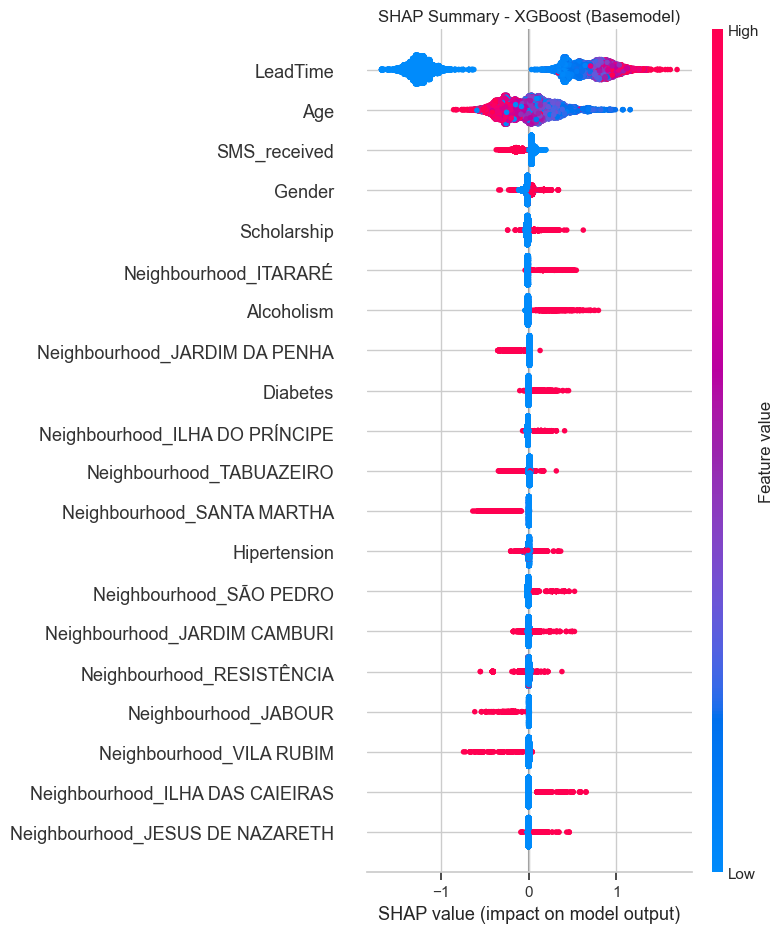


--- Running models with NCR data ---
y_train: Counter({0: 41565, 1: 16155})
y_test : Counter({0: 15961, 1: 4039})
X_train shape: (57720, 89)
X_test shape : (20000, 89)
Training LogisticRegression with NCR sampling...
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     15961
           1       0.34      0.19      0.25      4039

    accuracy                           0.76     20000
   macro avg       0.58      0.55      0.55     20000
weighted avg       0.72      0.76      0.74     20000

Best Params for LogisticRegression (NCR): {'model__C': 0.01}
Training DecisionTree with NCR sampling...
              precision    recall  f1-score   support

           0       0.85      0.79      0.82     15961
           1       0.36      0.46      0.40      4039

    accuracy                           0.72     20000
   macro avg       0.60      0.63      0.61     20000
weighted avg       0.75      0.72      0.74     20000

Best Params for Decision

 98%|===================| 19550/20000 [00:38<00:00]        

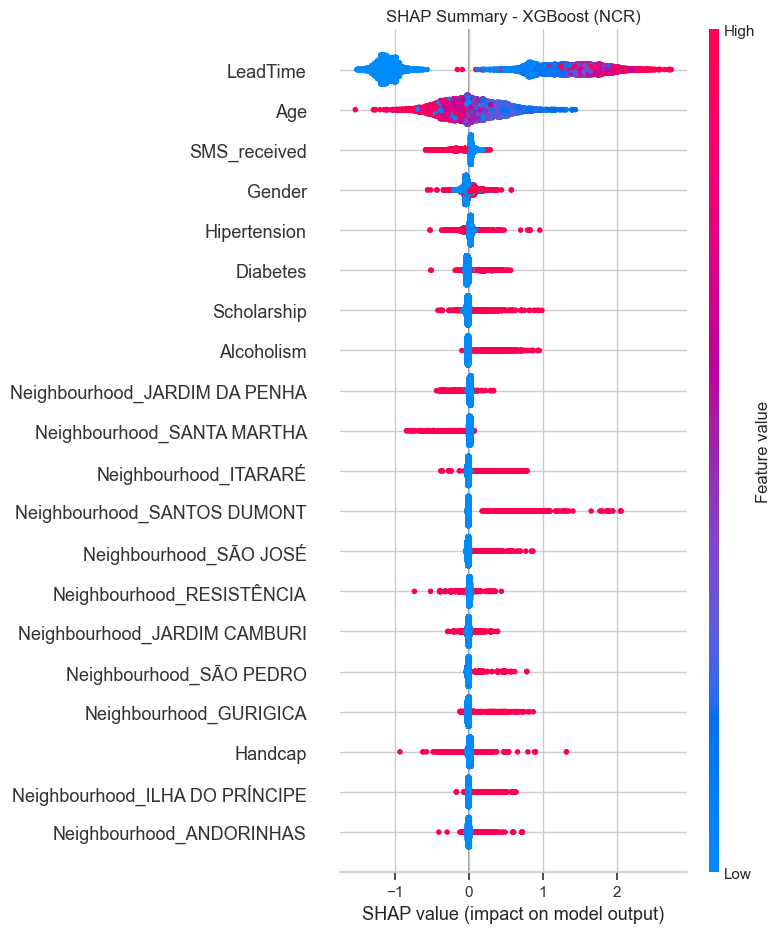


--- Running models with RUS data ---
y_train: Counter({0: 16155, 1: 16155})
y_test : Counter({0: 15961, 1: 4039})
X_train shape: (32310, 89)
X_test shape : (20000, 89)
Training LogisticRegression with RUS sampling...
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     15961
           1       0.30      0.57      0.40      4039

    accuracy                           0.65     20000
   macro avg       0.58      0.62      0.57     20000
weighted avg       0.75      0.65      0.68     20000

Best Params for LogisticRegression (RUS): {'model__C': 1}
Training DecisionTree with RUS sampling...
              precision    recall  f1-score   support

           0       0.91      0.55      0.69     15961
           1       0.31      0.79      0.44      4039

    accuracy                           0.60     20000
   macro avg       0.61      0.67      0.56     20000
weighted avg       0.79      0.60      0.64     20000

Best Params for DecisionTre

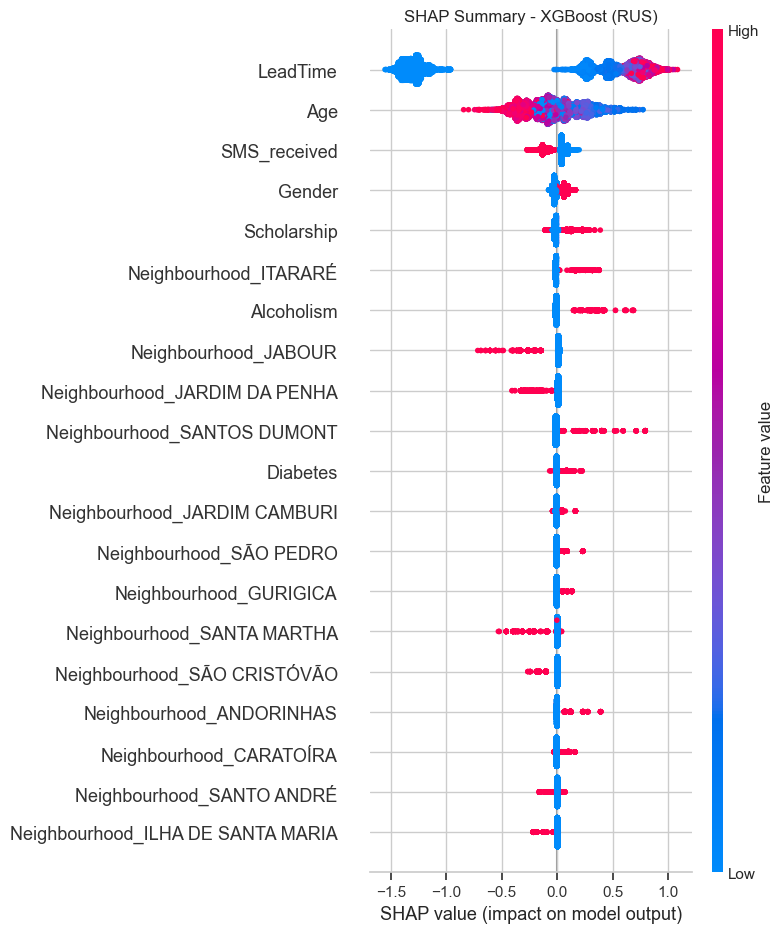


--- Running models with SMOTE data ---
y_train: Counter({0: 63845, 1: 63845})
y_test : Counter({0: 15961, 1: 4039})
X_train shape: (127690, 89)
X_test shape : (20000, 89)
Training LogisticRegression with SMOTE sampling...
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     15961
           1       0.31      0.58      0.40      4039

    accuracy                           0.65     20000
   macro avg       0.58      0.62      0.58     20000
weighted avg       0.75      0.65      0.68     20000

Best Params for LogisticRegression (SMOTE): {'model__C': 10}
Training DecisionTree with SMOTE sampling...
              precision    recall  f1-score   support

           0       0.87      0.70      0.78     15961
           1       0.33      0.59      0.42      4039

    accuracy                           0.68     20000
   macro avg       0.60      0.64      0.60     20000
weighted avg       0.76      0.68      0.70     20000

Best Params for D

 99%|===================| 19724/20000 [00:43<00:00]        

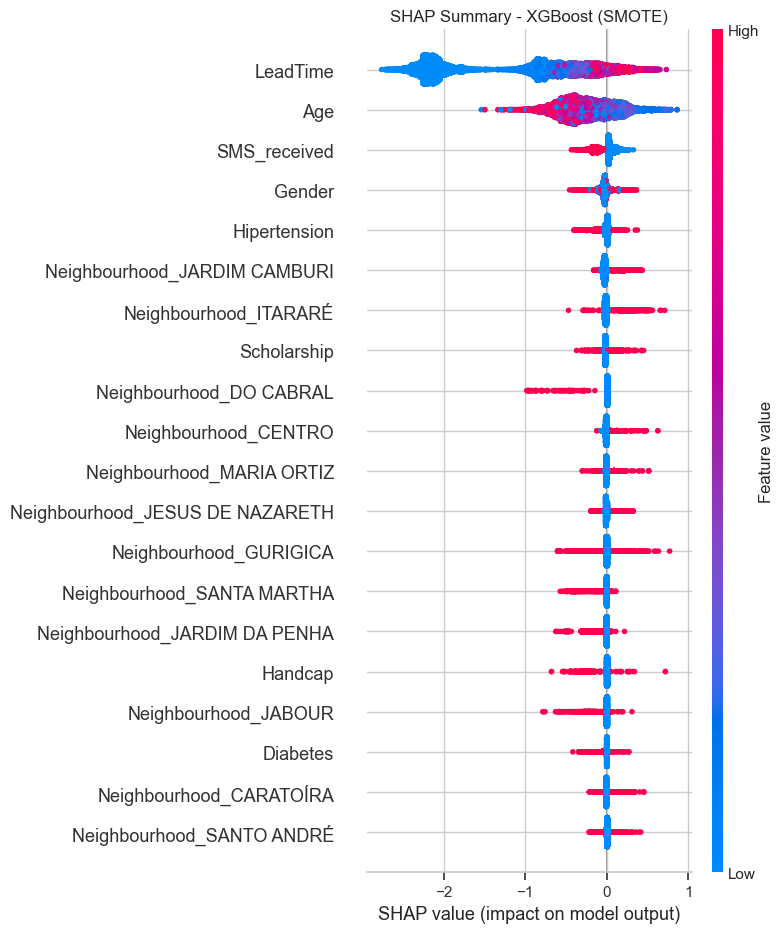


Model Performance Summary:
                             model  accuracy  balanced_accuracy   roc_auc  \
0   LogisticRegression (Basemodel)   0.79495           0.503328  0.653023   
1         DecisionTree (Basemodel)   0.79795           0.502249  0.714750   
2         RandomForest (Basemodel)   0.79805           0.500000  0.718892   
3              XGBoost (Basemodel)   0.79685           0.510344  0.725986   
4         LogisticRegression (NCR)   0.76250           0.549019  0.655009   
5               DecisionTree (NCR)   0.72270           0.625889  0.708072   
6               RandomForest (NCR)   0.78835           0.523882  0.710293   
7                    XGBoost (NCR)   0.73770           0.630293  0.727090   
8         LogisticRegression (RUS)   0.65035           0.619211  0.656817   
9               DecisionTree (RUS)   0.59925           0.669121  0.715310   
10              RandomForest (RUS)   0.57060           0.667999  0.716205   
11                   XGBoost (RUS)   0.59570    

In [18]:
# Store feature names
feature_names = X.columns.tolist()

# Train-test split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Sampling strategies
sampling_strategies = {
    'Basemodel': None,
    'NCR': NeighbourhoodCleaningRule(),
    'RUS': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42)
}

# Models and hyperparameter grids
model_grid = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'model__C': [0.01, 0.1, 1, 10]}
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params': {'model__max_depth': [3, 5, 10]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [50, 100], 'model__max_depth': [5, 10]}
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss'),
        'params': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5]}
    }
}

# Storage
results = []
roc_data = {}
feature_importances = {}
shap_values_store = {}
conf_matrices = []
conf_titles = []

# SHAP config
shap_models = ['XGBoost']
shap_samplers = sampling_strategies.keys()

# Training and evaluation
for sampler_label, sampler in sampling_strategies.items():
    print(f"\n--- Running models with {sampler_label} data ---")

    if sampler:
        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    else:
        X_train_res, y_train_res = X_train.copy(), y_train.copy()

    print("y_train:", Counter(y_train_res))
    print("y_test :", Counter(y_test))
    print("X_train shape:", X_train_res.shape)
    print("X_test shape :", X_test.shape)

    for model_name, config in model_grid.items():
        try:
            print(f"Training {model_name} with {sampler_label} sampling...")
            pipeline = Pipeline([('model', config['model'])])
            grid = GridSearchCV(pipeline, config['params'], cv=3, scoring='roc_auc', n_jobs=-1)
            grid.fit(X_train_res, y_train_res)

            y_pred = grid.predict(X_test)
            y_proba = grid.predict_proba(X_test)[:, 1]

            # Store metrics + best params
            best_params = grid.best_params_
            results.append({
                'model': f"{model_name} ({sampler_label})",
                'accuracy': accuracy_score(y_test, y_pred),
                'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_proba),
                'precision': precision_score(y_test, y_pred, zero_division=0),
                'recall': recall_score(y_test, y_pred, zero_division=0),
                'f1_score': f1_score(y_test, y_pred, zero_division=0),
                'best_params': best_params
            })

            print(classification_report(y_test, y_pred))
            print(f"Best Params for {model_name} ({sampler_label}): {best_params}")

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            conf_matrices.append(cm)
            conf_titles.append(f"{model_name} ({sampler_label})")

            # ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_data[f"{model_name} ({sampler_label})"] = (fpr, tpr)

            # Feature importance
            base_model = grid.best_estimator_.named_steps['model']
            if hasattr(base_model, 'feature_importances_'):
                feature_importances[f"{model_name} ({sampler_label})"] = base_model.feature_importances_
            elif hasattr(base_model, 'coef_'):
                feature_importances[f"{model_name} ({sampler_label})"] = np.abs(base_model.coef_[0])
            else:
                print(f"No feature importance for {model_name} ({sampler_label})")

            # SHAP
            if model_name in shap_models and sampler_label in shap_samplers:
                print(f"Generating SHAP values for {model_name} ({sampler_label})...")
                explainer = shap.Explainer(base_model, X_train_res)
                shap_values = explainer(X_test)
                shap_values_store[f"{model_name} ({sampler_label})"] = shap_values

                shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
                plt.title(f"SHAP Summary - {model_name} ({sampler_label})")
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"Error training {model_name} ({sampler_label}): {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df[['model', 'accuracy', 'balanced_accuracy', 'roc_auc', 'best_params']])

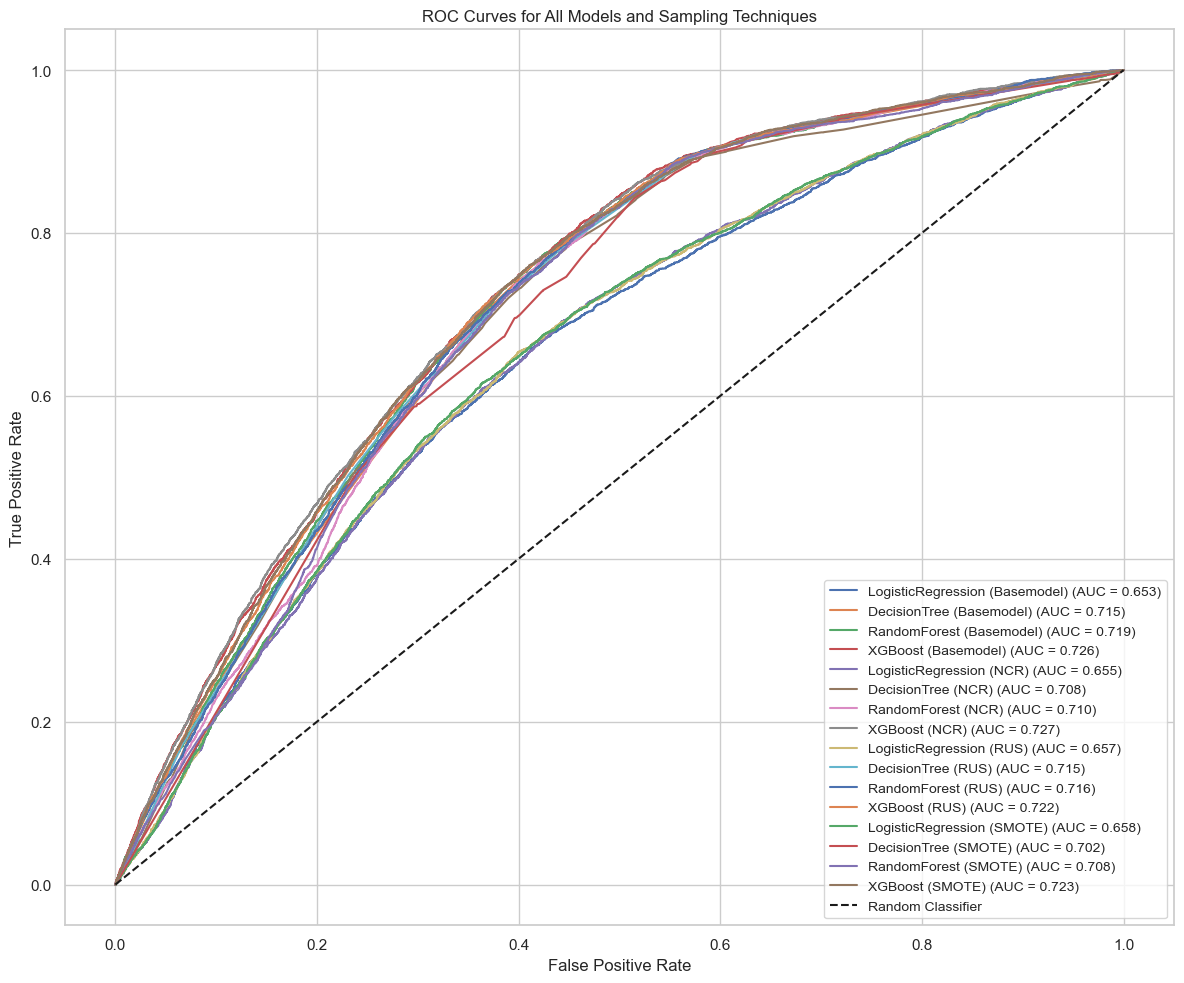

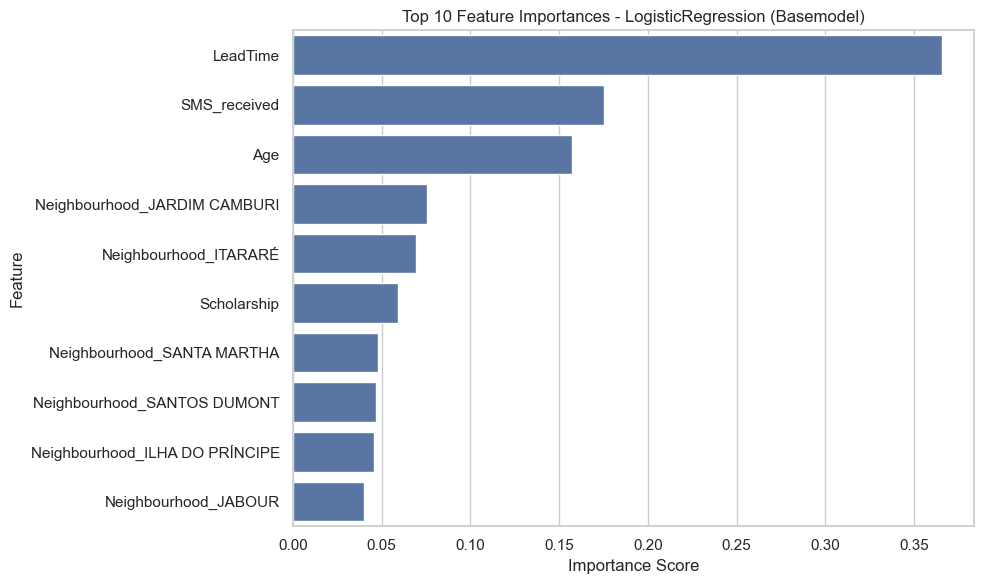

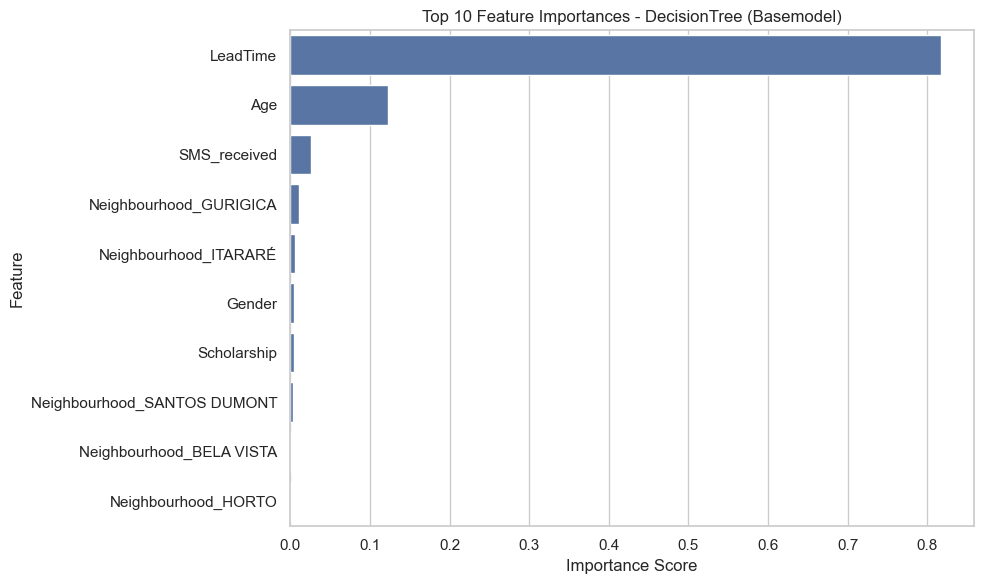

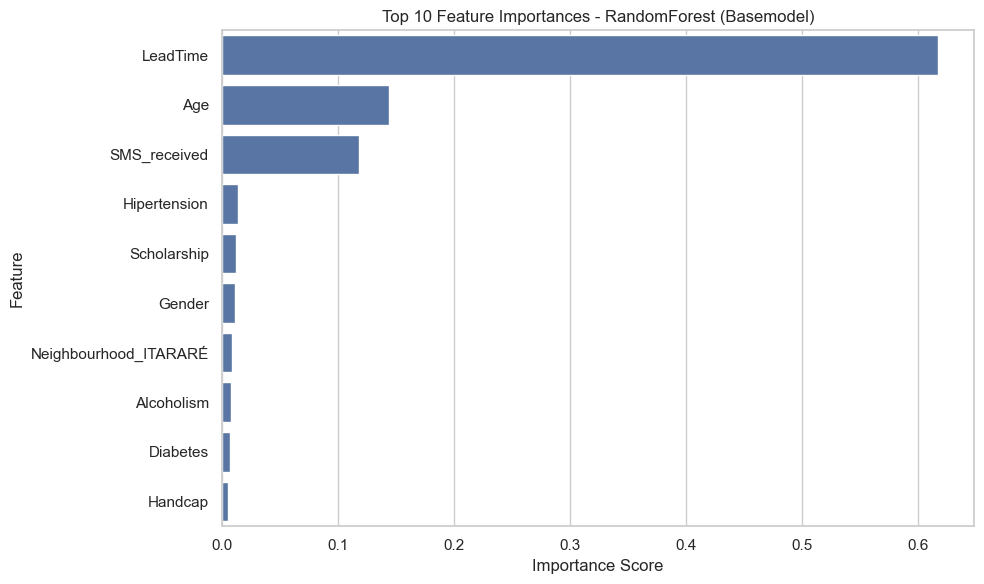

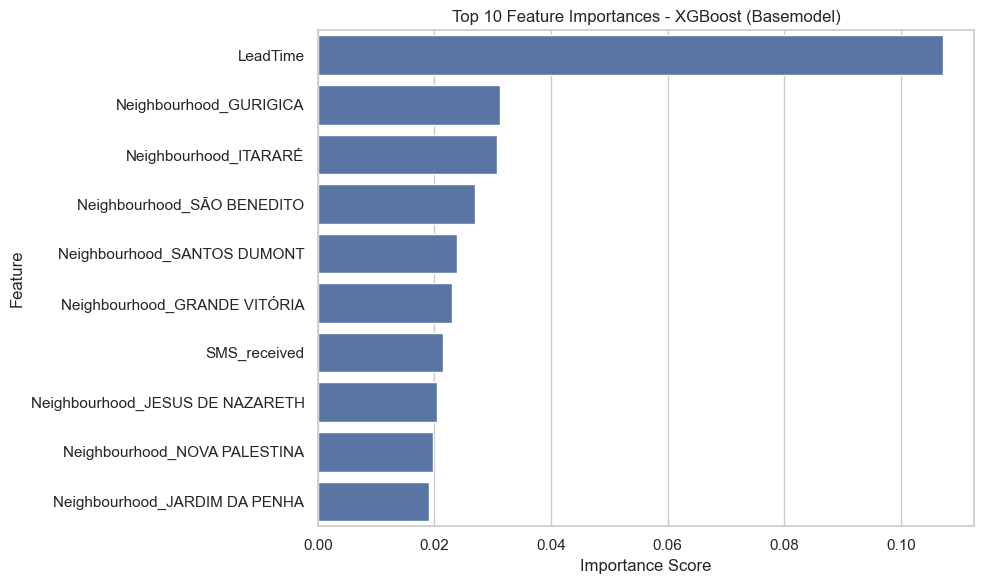

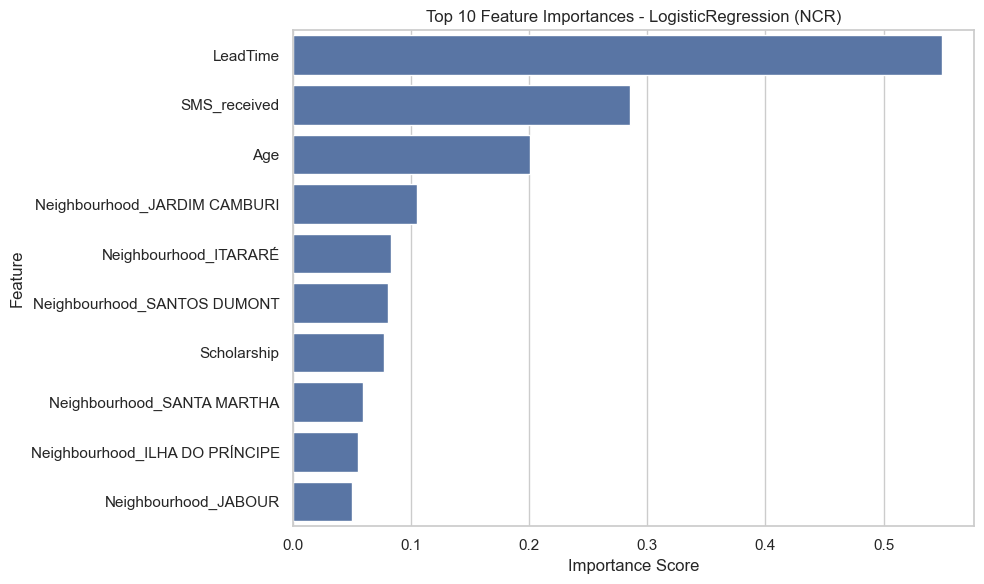

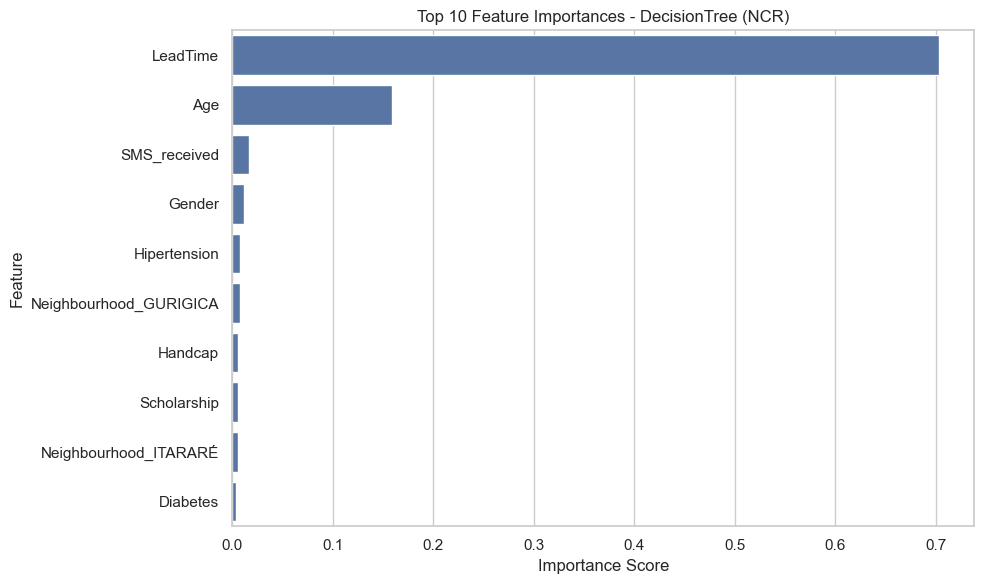

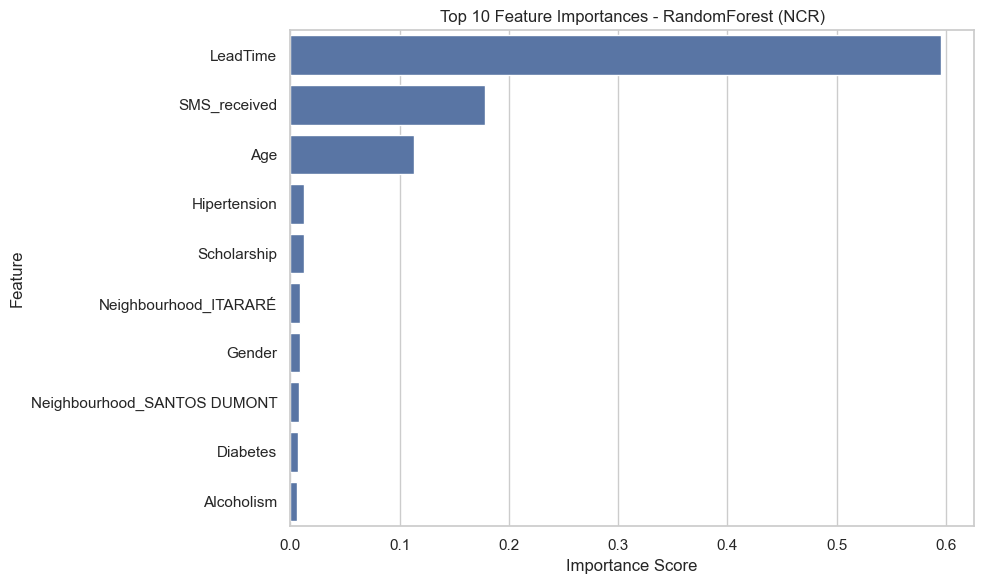

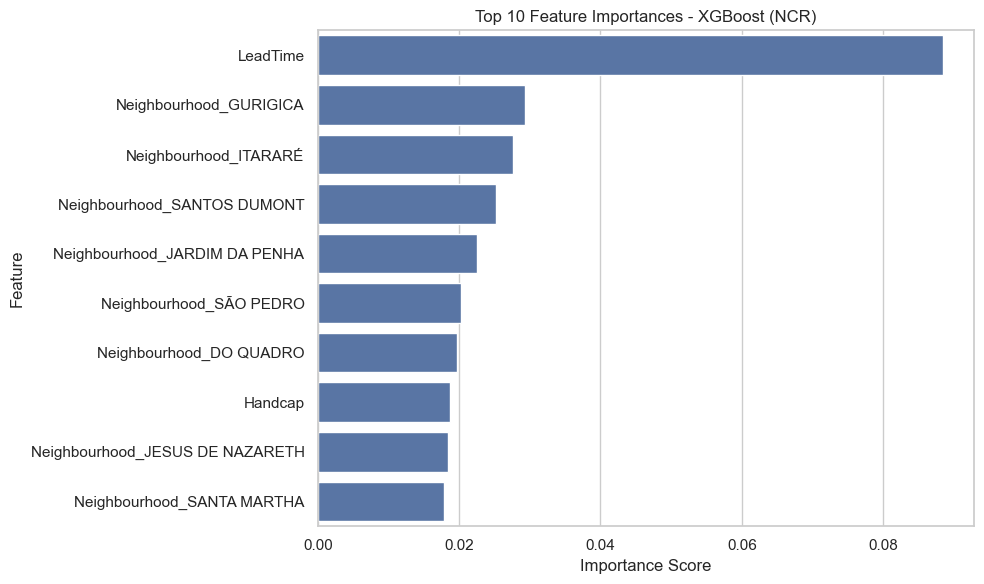

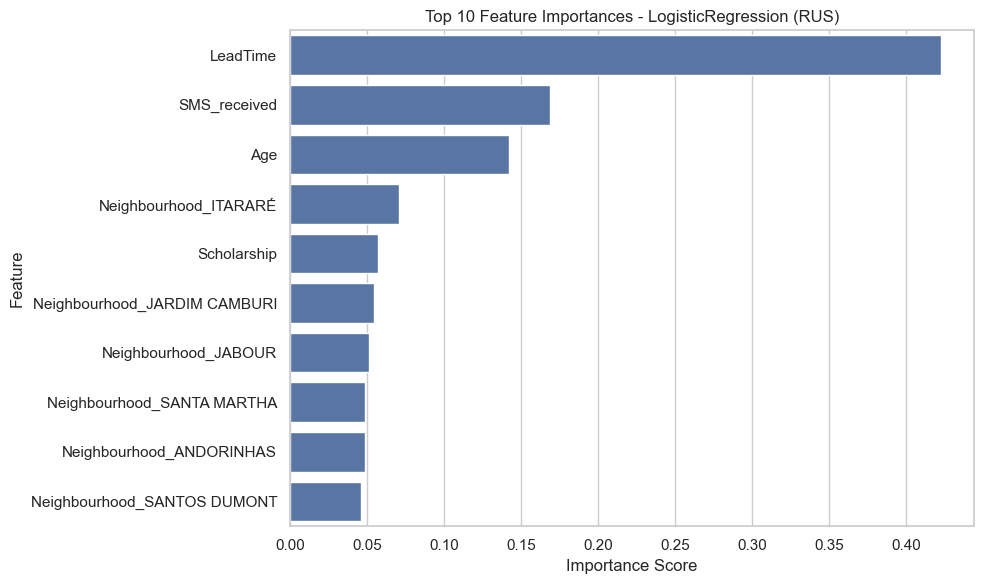

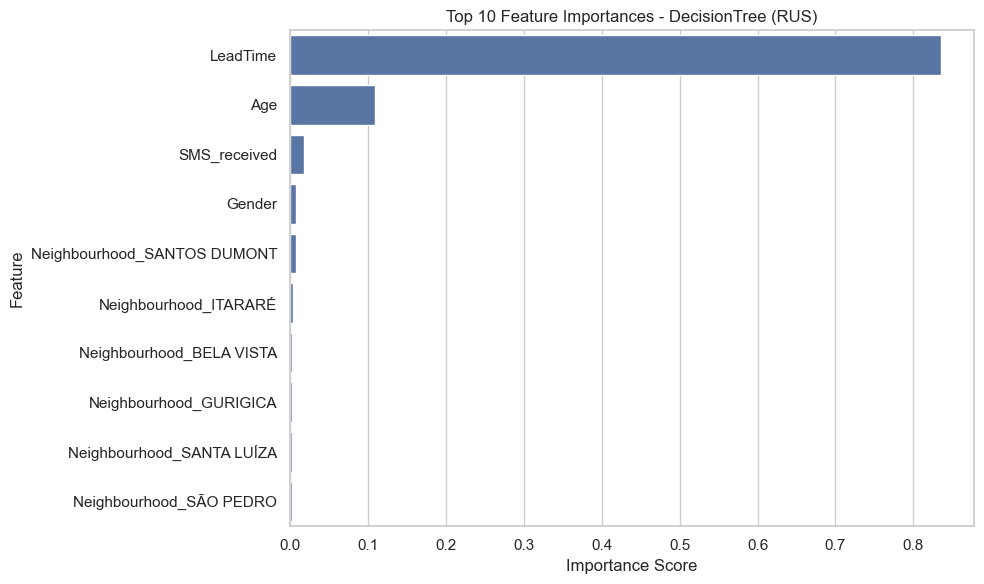

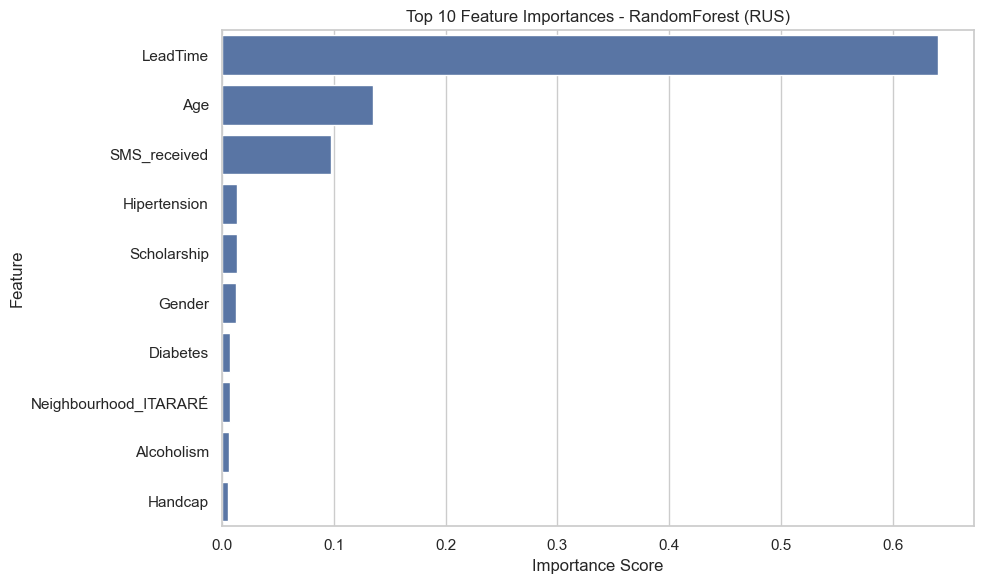

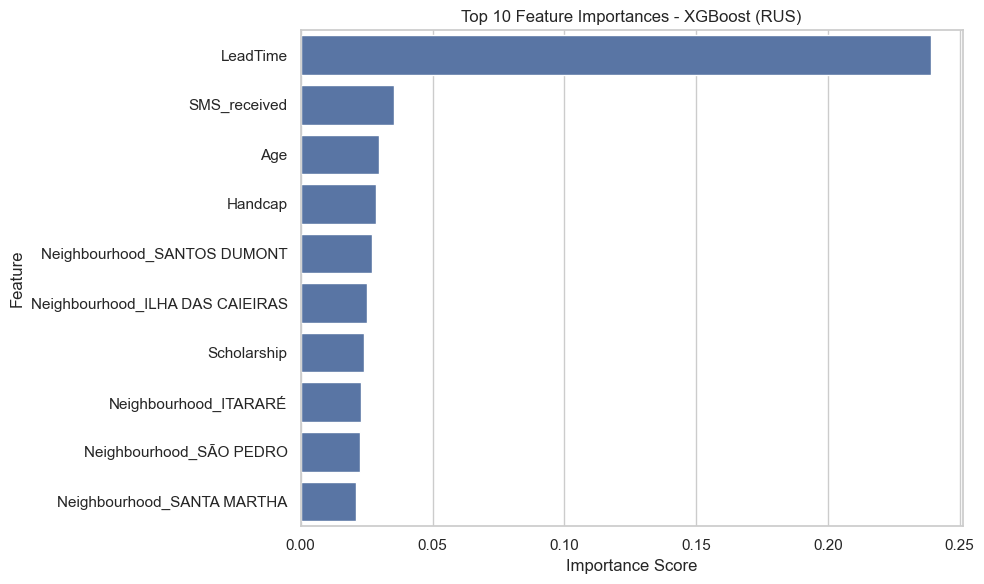

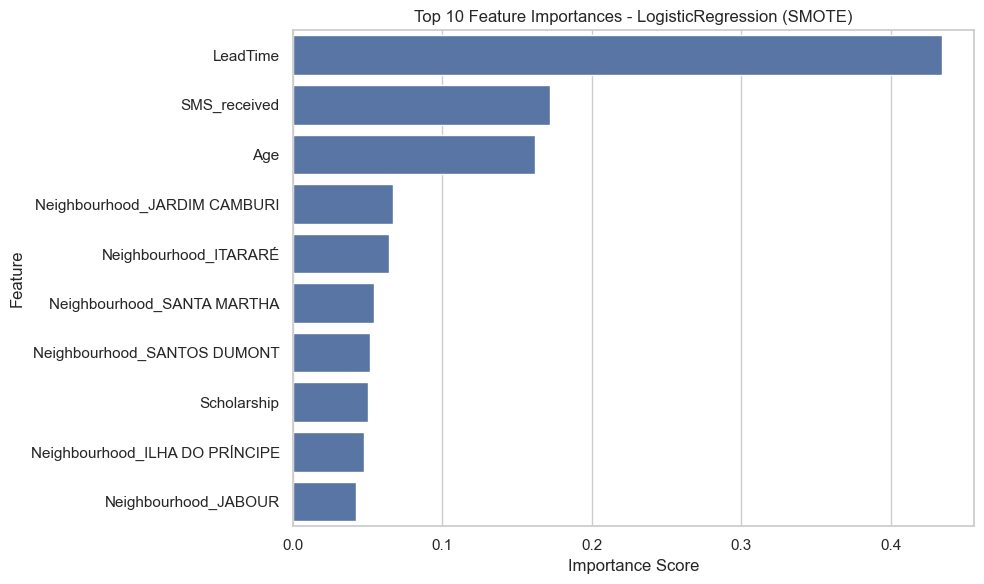

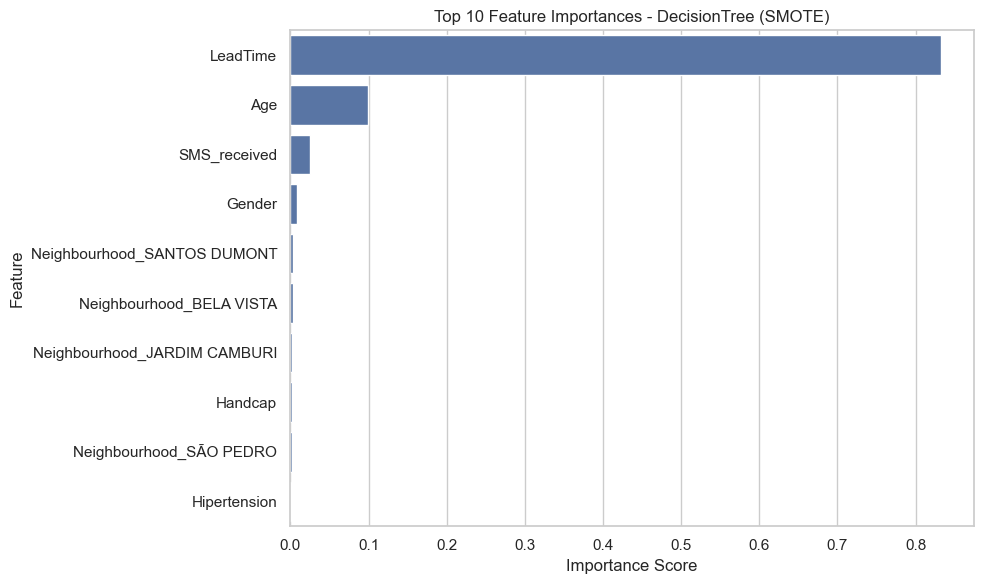

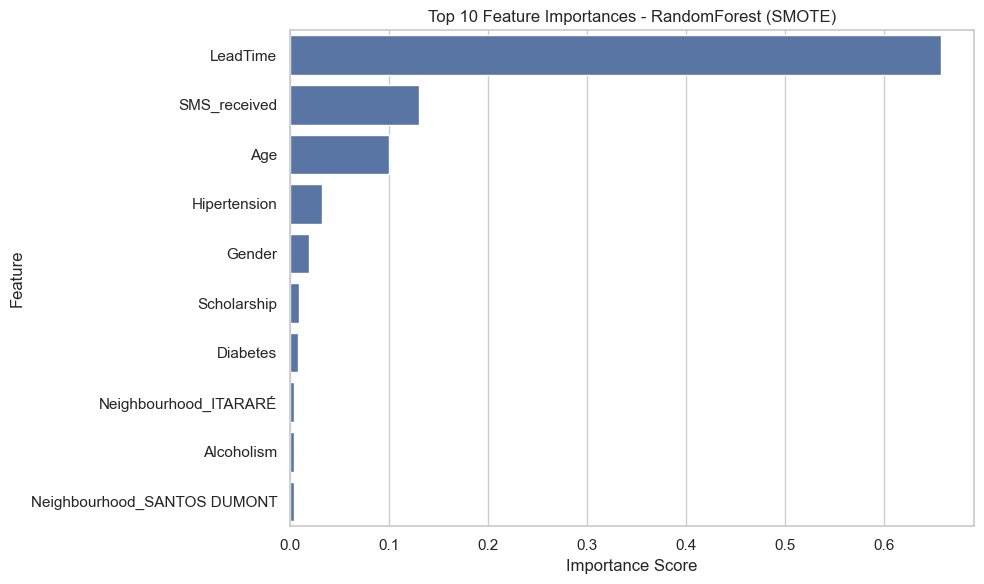

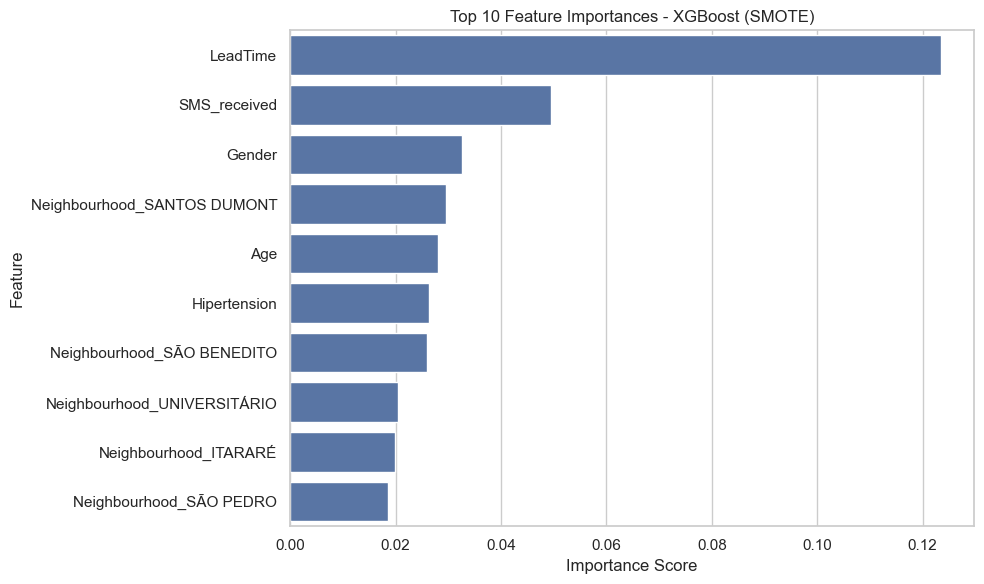

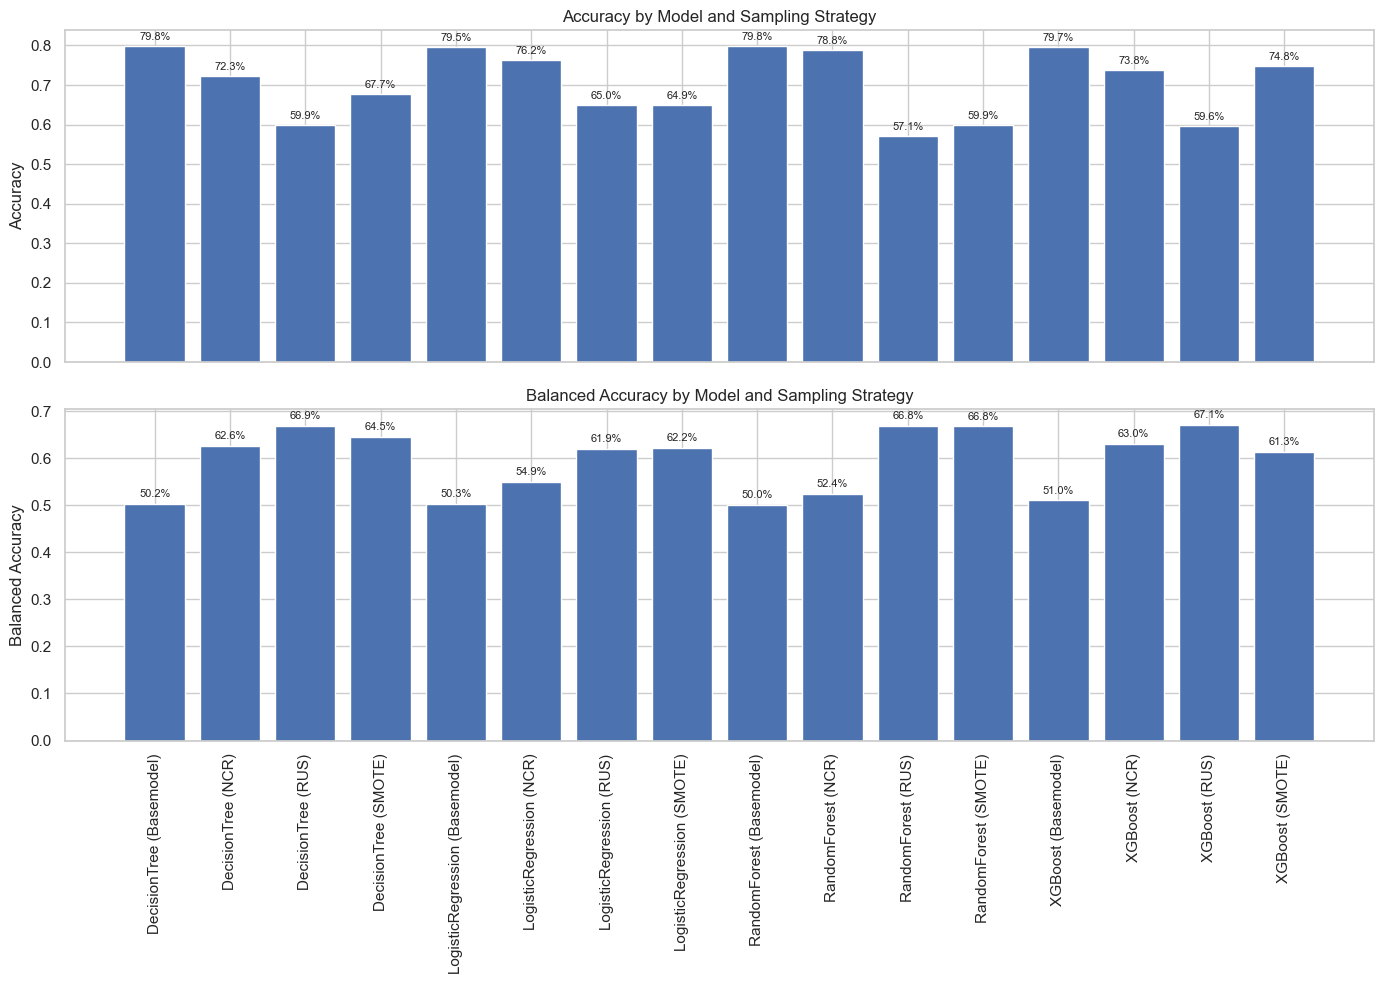

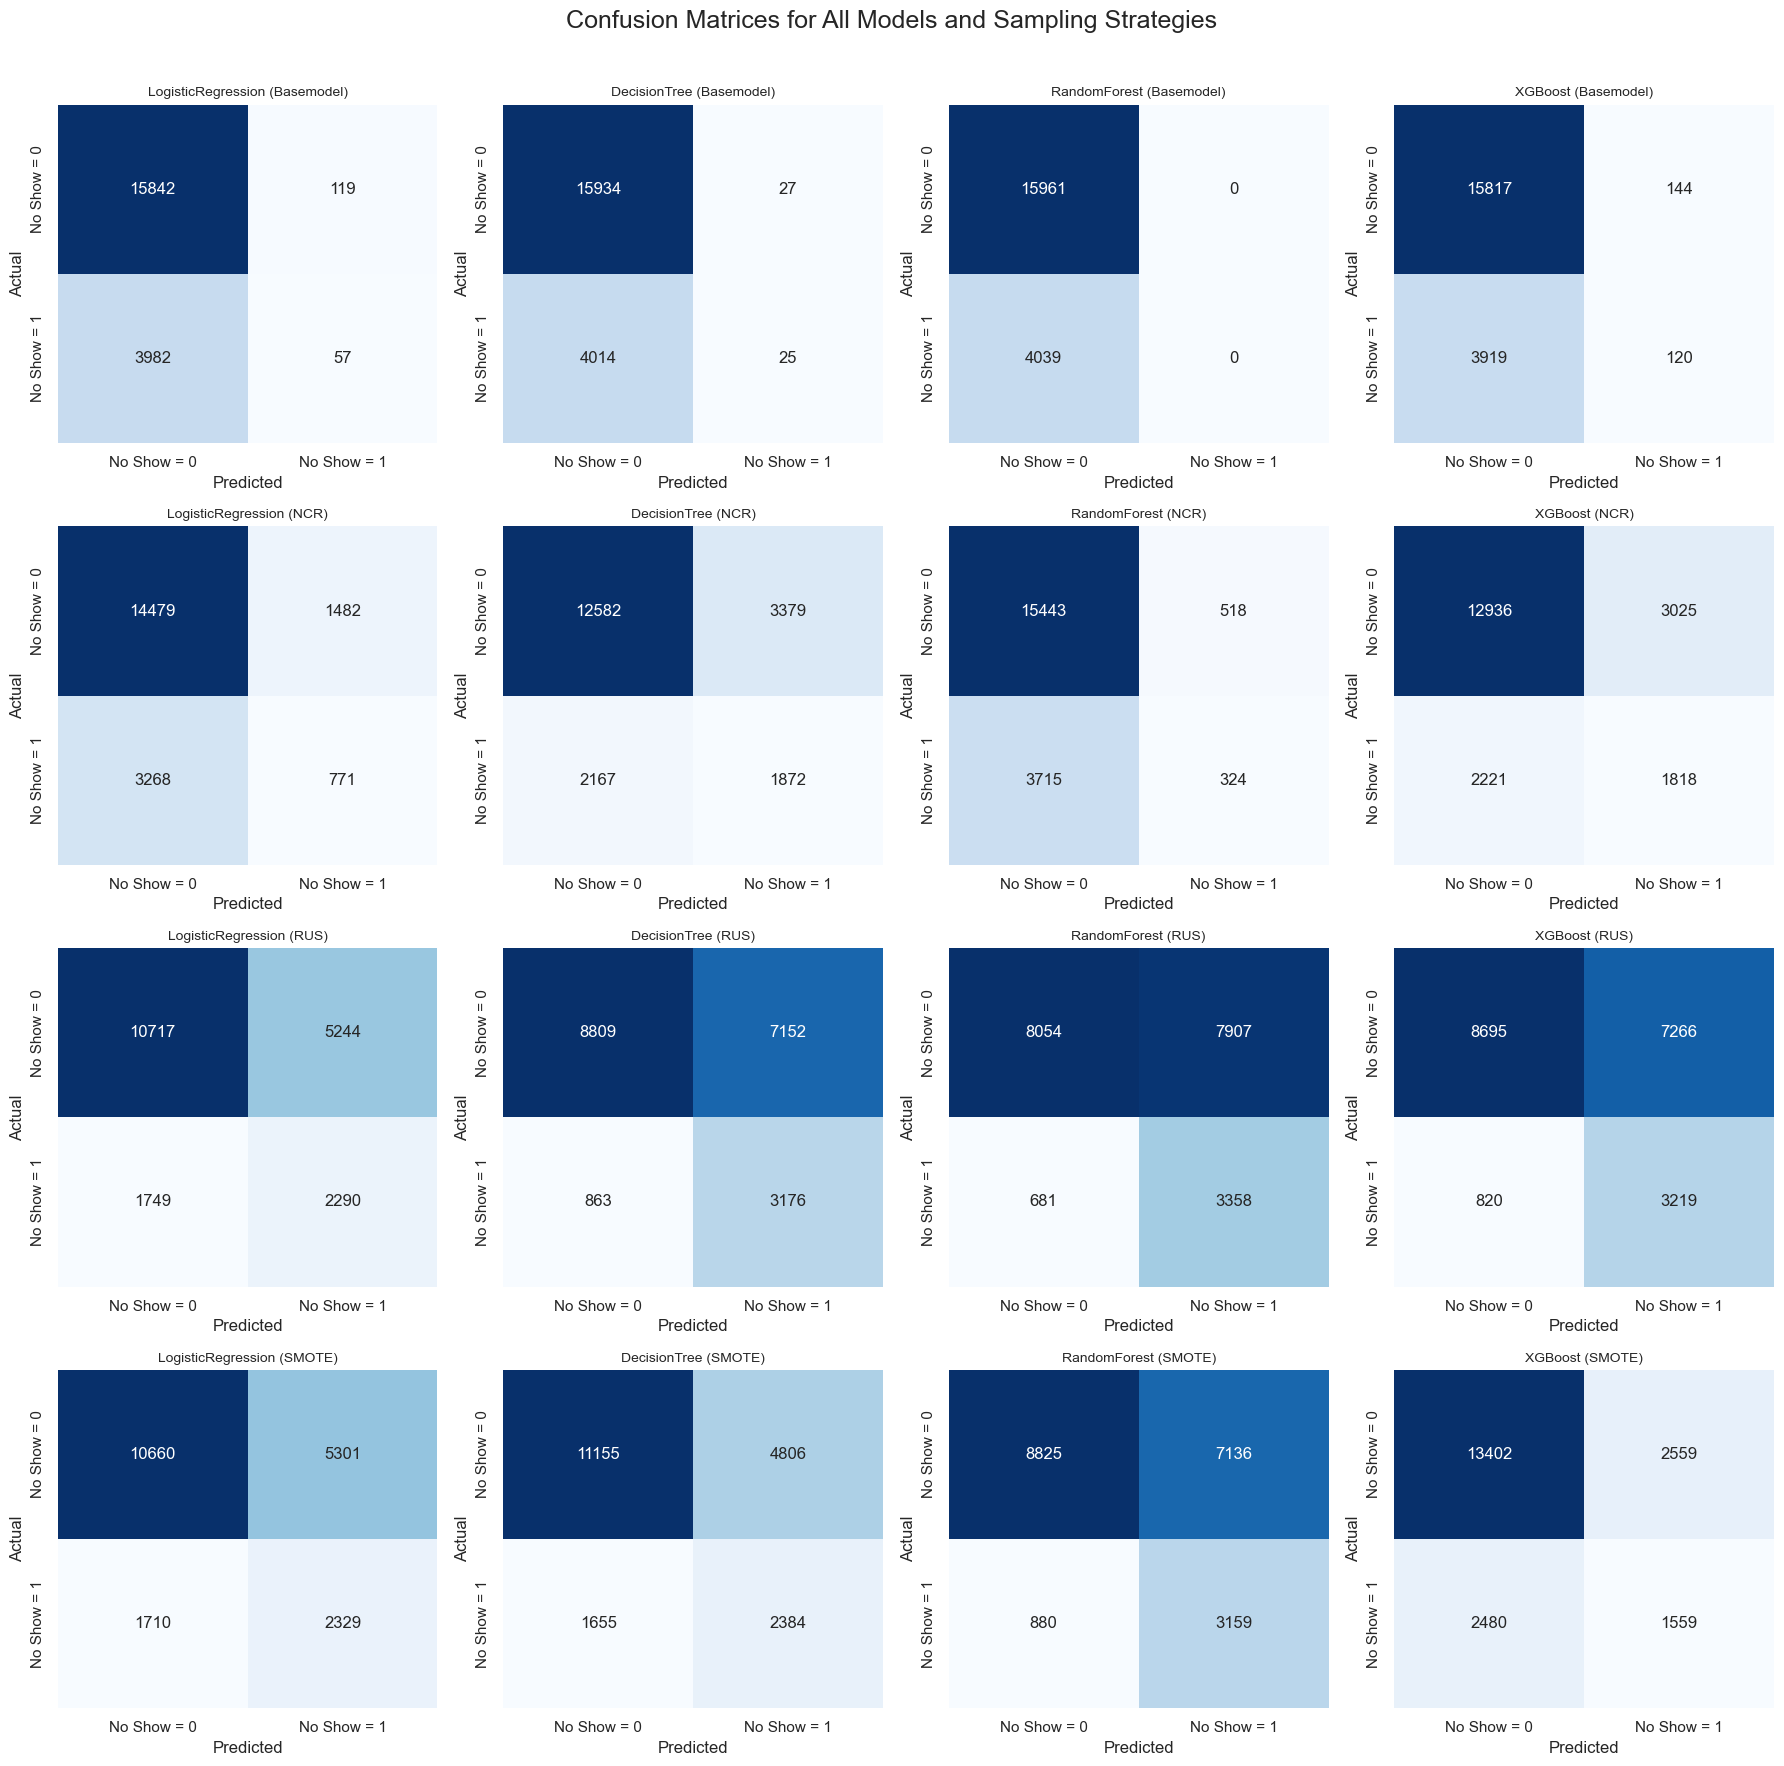

In [19]:
# --- ROC Curves with AUC Values in Legend ---
plt.figure(figsize=(12, 10))

# Build a lookup for AUC values
auc_lookup = dict(zip(results_df['model'], results_df['roc_auc']))

# Plot each ROC curve
for label, (fpr, tpr) in roc_data.items():
    auc = auc_lookup.get(label, None)
    label_with_auc = f"{label} (AUC = {auc:.3f})" if auc is not None else label
    plt.plot(fpr, tpr, label=label_with_auc)

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curves for All Models and Sampling Techniques')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Importance Plots for All Models and Sampling Techniques ---
for model_label, importances in feature_importances.items():
    try:
        # Convert to Series for better plotting
        imp_series = pd.Series(importances, index=feature_names)
        imp_series = imp_series.sort_values(ascending=False)[:10]  # Top 10 features

        plt.figure(figsize=(10, 6))
        sns.barplot(x=imp_series.values, y=imp_series.index)
        plt.title(f"Top 10 Feature Importances - {model_label}")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error plotting feature importance for {model_label}: {e}")


# --- Accuracy and Balanced Accuracy Bar Charts ---
results_df_sorted = results_df.sort_values(by='model')

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Accuracy
axes[0].bar(results_df_sorted['model'], results_df_sorted['accuracy'])
axes[0].set_title('Accuracy by Model and Sampling Strategy')
axes[0].set_ylabel('Accuracy')
axes[0].tick_params(axis='x', rotation=90)
for idx, value in enumerate(results_df_sorted['accuracy']):
    axes[0].text(idx, value + 0.01, f"{value:.1%}", ha='center', va='bottom', fontsize=8)

# Balanced Accuracy
axes[1].bar(results_df_sorted['model'], results_df_sorted['balanced_accuracy'])
axes[1].set_title('Balanced Accuracy by Model and Sampling Strategy')
axes[1].set_ylabel('Balanced Accuracy')
axes[1].tick_params(axis='x', rotation=90)
for idx, value in enumerate(results_df_sorted['balanced_accuracy']):
    axes[1].text(idx, value + 0.01, f"{value:.1%}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# --- Confusion Matrix Grid (4x4) ---
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
fig.suptitle("Confusion Matrices for All Models and Sampling Strategies", fontsize=18)

for i, ax in enumerate(axes.flat):
    if i < len(conf_matrices):
        sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['No Show = 0', 'No Show = 1'],
                    yticklabels=['No Show = 0', 'No Show = 1'], ax=ax)
        ax.set_title(conf_titles[i], fontsize=10)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
    else:
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Accuracy, Balanced Accuracy, and AUC-ROC were selected as the key evaluation metrics because they provide a balanced and interpretable view of model performance, particularly in imbalanced classification tasks like healthcare predictions. Accuracy reflects the proportion of total correct predictions, including both true positives and true negatives. However, when one class dominates the dataset, accuracy alone can be misleading. Balanced Accuracy addresses this by averaging sensitivity (the model’s ability to correctly identify true positives) and specificity (its ability to correctly identify true negatives), offering a fairer reflection of performance across both classes (Guesné et al., 2024). AUC-ROC complements these by measuring how well the model separates positive from negative cases across all thresholds, providing a threshold-independent indicator of classification quality.



=== Percentage Difference Compared to Basemodel (Core Metrics Only) ===
             Model Sampling  Accuracy % Diff  Balanced Accuracy % Diff  ROC-AUC Score % Diff
LogisticRegression      NCR        -4.082018                  9.077650              0.304161
      DecisionTree      NCR        -9.430415                 24.617222             -0.934304
      RandomForest      NCR        -1.215463                  4.776377             -1.196054
           XGBoost      NCR        -7.422978                 23.503611              0.151980
LogisticRegression      RUS       -18.189823                 23.023186              0.581020
      DecisionTree      RUS       -24.901310                 33.224854              0.078277
      RandomForest      RUS       -28.500721                 33.599888             -0.373756
           XGBoost      RUS       -25.243145                 31.454899             -0.596708
LogisticRegression    SMOTE       -18.303038                 23.627627              0.7020

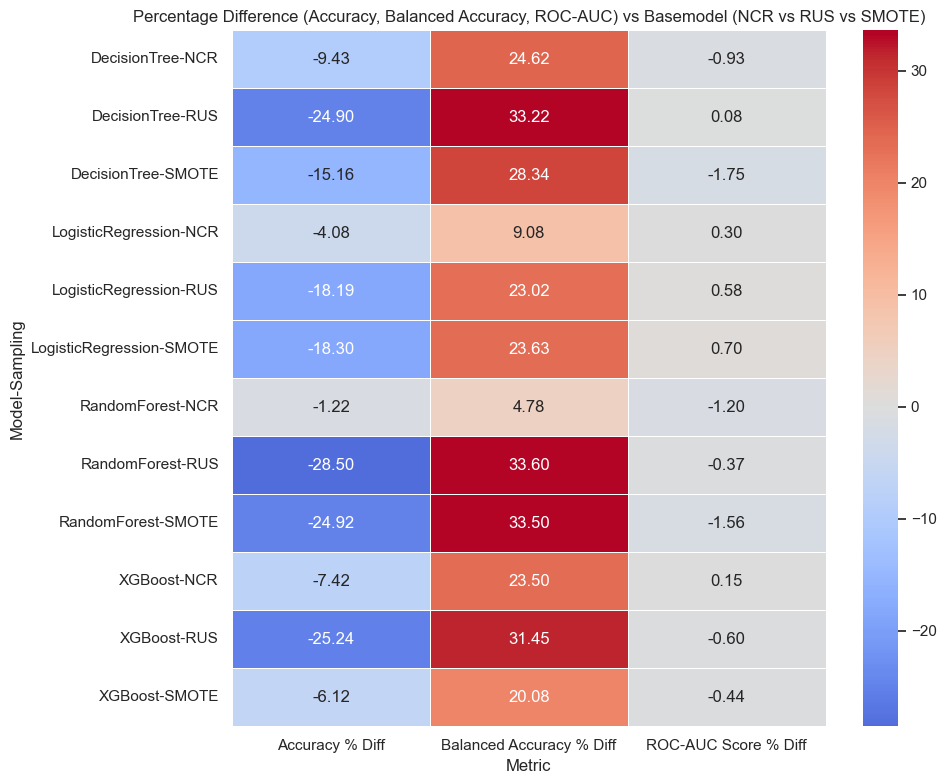

In [20]:
# === Percentage Difference Compared to Basemodel (Core Metrics Only) ===
# Identify key metrics
results_df_renamed = results_df.rename(columns={
    'accuracy': 'Accuracy',
    'balanced_accuracy': 'Balanced Accuracy',
    'roc_auc': 'ROC-AUC Score'
})

# Extract model name and sampling strategy
results_df_renamed['Model'] = results_df_renamed['model'].apply(lambda x: x.split(' ')[0])
results_df_renamed['Sampling'] = results_df_renamed['model'].apply(lambda x: x.split('(')[-1].replace(')', ''))

# Select only core metrics
core_metrics = ['Accuracy', 'Balanced Accuracy', 'ROC-AUC Score']

# Split into baseline and comparison sets
base_df = results_df_renamed[results_df_renamed['Sampling'] == 'Basemodel'].set_index('Model')
comparison_df = results_df_renamed[results_df_renamed['Sampling'] != 'Basemodel'].set_index('Model')

# Join comparison with baseline metrics
comparison_with_base = comparison_df.join(
    base_df[core_metrics],
    lsuffix='_Current',
    rsuffix='_Basemodel',
    on='Model'
).reset_index()

# Compute % differences
for metric in core_metrics:
    current = f"{metric}_Current"
    base = f"{metric}_Basemodel"
    comparison_with_base[f"{metric} % Diff"] = (
        (comparison_with_base[current] - comparison_with_base[base]) / comparison_with_base[base]
    ) * 100

# Create summary table
percent_diff_cols = ['Model', 'Sampling'] + [f"{metric} % Diff" for metric in core_metrics]
percent_diff_df = comparison_with_base[percent_diff_cols]

# Display result
print("\n=== Percentage Difference Compared to Basemodel (Core Metrics Only) ===")
print(percent_diff_df.to_string(index=False))

# Prepare for heatmap
melted_pct = pd.melt(
    percent_diff_df,
    id_vars=['Model', 'Sampling'],
    var_name='Metric',
    value_name='Percentage Difference'
)

pivot_pct = melted_pct.pivot_table(index=['Model', 'Sampling'], columns='Metric', values='Percentage Difference')

# --- Clean up for heatmap ---
pivot_pct.replace([np.inf, -np.inf], np.nan, inplace=True)
pivot_pct.fillna(0, inplace=True)
pivot_pct = pivot_pct.clip(lower=-100, upper=100)

# Plot heatmap
plt.figure(figsize=(10, 2 + 0.5 * len(pivot_pct)))
sns.heatmap(pivot_pct, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

# Title
strategies = results_df_renamed['Sampling'].unique().tolist()
if 'Basemodel' in strategies:
    strategies.remove('Basemodel')
strategy_title = " vs ".join(strategies)
plt.title(f"Percentage Difference (Accuracy, Balanced Accuracy, ROC-AUC) vs Basemodel ({strategy_title})")

plt.tight_layout()
plt.show()